# Evaluate LG3 , LG4 (LG3 + AF filter) : on ClinVar

1. LG4: if use AF filter , then add function `def filter_AF`; 
2. LG3: if not, only see the LG3 pred, then comment the function 

Method:  
* confusion matrix , precision, recall, f1 
* variants: all pathogenic and benign, uncertain, missense variants, splicing variants
* compare with CADD, RankScore



In [2]:
import gzip
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.compose import make_column_transformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

/Users/nancy/miniconda3/envs/bioinfo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# get prediction from model

## predict clinvar

In [3]:
""" FIRST of ALL-- user need"""

##### please set files
# in
# vcfgz_in_file = '/Users/nancy/Desktop/RS_projects/data/03_ML/03_predict_new/01_featureV1/justhusky_gatkcomb_rhocall_norm_af_mt_frqf_cadd_vep_parsed_ranked.vcf.gz'
variant_consequences_order = './variant_consequences.txt'

# out
# pred_out_simple = '/Users/nancy/Desktop/RS_projects/result/04_ML_modify/02_evaluate/01_Clinvar_pred-29feats_CJP5-5_LG.csv'


##### load fitted preprocessor and model
preprocessor = load('/Users/nancy/Desktop/RS_projects/result/04_ML_modify/01_retrainModel_ClinvarJusthuskyNewpatho/models/02_12feats_ClinJustPatho5-5_preprocessor.joblib') # data preprocessor
LG_model = load('/Users/nancy/Desktop/RS_projects/result/04_ML_modify/01_retrainModel_ClinvarJusthuskyNewpatho/models/02_12feats_ClinJustPatho5-5_LG.joblib')         # logistic regression model


In [4]:
## predict


df=pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';')  ## exracted clinvar data
df['idx'] = df.index  # add index column

""" 2.1 choose featuresV1"""

featureV1 = ['idx','CADD', 'AF_TGP', 'Frq', 'IMPACT','GNOMADAF_popmax', 'Hom', 'ORIGIN',
       'SPIDEX', 'SWEGENAF', 'Consequence', 'BIOTYPE', 'SIFT',
       'PolyPhen', 'MES-SWA_acceptor_alt', 'MES-SWA_acceptor_diff',
       'MES-SWA_donor_alt', 'MES-SWA_donor_diff', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'GERP++_RS', 'REVEL_score',
       'phastCons100way_vertebrate', 'phyloP100way_vertebrate', 'LoFtool',
       'pLI_gene_value', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL']         # remove CLNSIG,   add index: 29+1 total

df_1 = df[featureV1]



""" 2.2 preprocessing and predict """

## predict function :
def predict_score(X,model,df_ori):
    # Use preprocessor and model to predict on new data
    X_processed = preprocessor.transform(X)
    pred = model.predict(X_processed)
    prob = model.predict_proba(X_processed)

    # put prediction and score back to dataframe with same index
    df_out = pd.DataFrame(data = [pred,prob[:,1]]).T
    df_out.columns = ['prediction','score']
    df_out['score']=df_out['score'].round(3)
    df_out = pd.concat([X['idx'],df_out],axis=1)

    #  write model outputs in original df at same index rows
    df_copy = df_ori.copy() 
    df_merged = pd.merge(df_ori,df_out, on='idx')    # get only rows merged when index is same
    df_copy.loc[df_copy['idx'].isin(df_merged['idx']),['prediction','score']] = df_merged[['prediction','score']].values  # put cells of merged in original dataframe
    lst = ['idx','prediction','score']
    return df_copy[lst]

# data preprocessing and predicted by models
df_lg = predict_score(df_1,LG_model,df)

# df_lg.to_csv(pred_out_simple,index=False)




/var/folders/q0/2p8kfxsn7s73349btf1_g07h0000gp/T/ipykernel_3034/2656857793.py:4: DtypeWarning: Columns (32,49,50,51,54,56,58,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';')  ## exracted clinvar data


In [5]:
df

,CLNSIG,CADD,AF_ESP,AF_EXAC,AF_TGP,Frq,GNOMADAF,GNOMADAF_popmax,Hom,ORIGIN,...,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_pred_SYMBOL,genomic_superdups_frac_match,idx
0,Uncertain_significance,26.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,11.0,10.0,-30.0,0.01,0.00,0.09,0.00,SAMD11,NaN,0
1,Likely_benign,13.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-34.0,6.0,42.0,0.00,0.02,0.03,0.00,SAMD11,NaN,1
2,Likely_benign,31.000,NaN,NaN,NaN,0.00056,0.000414,0.000195,NaN,1.0,...,-47.0,-7.0,44.0,0.00,0.01,0.06,0.00,SAMD11,NaN,2
3,Uncertain_significance,28.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-47.0,34.0,-14.0,0.00,0.00,0.03,0.02,SAMD11,NaN,3
4,Likely_benign,11.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-50.0,12.0,24.0,0.00,0.00,0.01,0.00,SAMD11,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468907,Benign,7.587,NaN,NaN,NaN,0.00070,NaN,NaN,5.0,1.0,...,35.0,0.0,16.0,0.00,0.00,0.00,0.00,USP9Y,NaN,1468907
1468908,Uncertain_significance,23.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1468908
1468909,Benign,11.200,0.00614,0.00589,0.00243,0.00671,NaN,NaN,48.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1468909
1468910,Uncertain_significance,21.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1468910


In [6]:
## prediction with score

df_lg

,idx,prediction,score
0,0,1.0,0.519
1,1,0.0,0.006
2,2,1.0,0.732
3,3,1.0,0.687
4,4,0.0,0.004
...,...,...,...
1468907,1468907,0.0,0.002
1468908,1468908,1.0,0.911
1468909,1468909,0.0,0.020
1468910,1468910,1.0,0.881


In [7]:
df_lg.prediction.value_counts()

0.0    1063363
1.0     405549
Name: prediction, dtype: int64

## + AF filter : if any AF > 0.01 & patho, change patho to benign

In [8]:
""" function: filter prediction by AF > 0.01:
if minimum AF > 0.01 & patho, change patho to benign 

output: precdiction by model after filtering """


# function:  to get the minimum non-NaN value in a row
def min_nonnan(row):
    nonnan_vals = [val for val in row if not np.isnan(val)]
    return min(nonnan_vals) if nonnan_vals else np.nan


## function: transfer `predicted patho`` with any AF>=0.01, to `benign`
def filter_AF(df_extracted_ori,df_pred_out):

    af = ['AF_ESP', 'AF_EXAC', 'AF_TGP', 'Frq', 'GNOMADAF_popmax', 'SWEGENAF']
    df_af = df_extracted_ori[af]  # Extract all related to AF parameters from the data

    df_merge_af = pd.concat([df_pred_out, df_af], axis=1)
    df_merge_af['AF_min'] = df_merge_af[af].apply(min_nonnan, axis=1)   # create a new 'AF_min' column

    
    df_filter = df_merge_af.copy()
    df_filter.loc[(df_filter['prediction'] == 1) & (df_filter['AF_min'] >= 0.01), ['prediction']] = 0   # Change 'patho' to 'benign' when min 'AF' is >= 0.01

    # Extract the 'prediction' and 'score' columns from the filtered data
    df_pred_out_1 = df_filter[['prediction', 'score']]

    # Return the value counts of 'prediction'
    return df_pred_out_1

## prediction with score output
df_lg = filter_AF(df,df_lg)


In [9]:

df_lg.prediction.value_counts()

0.0    1063407
1.0     405505
Name: prediction, dtype: int64

## merge data: CADD,rankscore,clinsig,consequence

In [10]:
# get CADD and old rankscore for entire clinvar data
df_cadd_rankscore = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/02_data_analysis/01_cadd_rankscore_clnsig/02_cadd_rankscore_clnsig_clnsigconf.csv')
df_cadd_rankscore.drop('CLNSIGCONF', axis=1,inplace = True)

In [11]:
df_merge_out = pd.concat([df_lg,df_cadd_rankscore,df[['Consequence']]],axis=1)
df_merge_out

,prediction,score,CADD,RankScore,CLNSIG,Consequence
0,1.0,0.519,26.600,24.0,Uncertain_significance,missense_variant
1,0.0,0.006,13.420,15.0,Likely_benign,synonymous_variant
2,1.0,0.732,31.000,21.0,Likely_benign,missense_variant
3,1.0,0.687,28.200,22.0,Uncertain_significance,missense_variant
4,0.0,0.004,11.380,13.0,Likely_benign,synonymous_variant
...,...,...,...,...,...,...
1468907,0.0,0.002,7.587,10.0,Benign,synonymous_variant
1468908,1.0,0.911,23.800,23.0,Uncertain_significance,missense_variant
1468909,0.0,0.020,11.200,13.0,Benign,synonymous_variant
1468910,1.0,0.881,21.600,20.0,Uncertain_significance,missense_variant


In [12]:
# change CLNSIG class:

        # """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
        # NOTE:
        # (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

        # 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
        # 2. benign: Likely_benign, Benign, Benign/Likely_benign
        # 3. uncertain: Uncertain_significance, 
        # 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_merge_out = df_merge_out.copy()
df_merge_out['CLNSIG'] = df_merge_out['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_merge_out['CLNSIG'] = df_merge_out['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_merge_out['CLNSIG'] = df_merge_out['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_merge_out['CLNSIG'] = df_merge_out['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')


In [13]:
df_merge_out.dropna(inplace=True)
df_merge_out

,prediction,score,CADD,RankScore,CLNSIG,Consequence
0,1.0,0.519,26.600,24.0,uncertain,missense_variant
1,0.0,0.006,13.420,15.0,benign,synonymous_variant
2,1.0,0.732,31.000,21.0,benign,missense_variant
3,1.0,0.687,28.200,22.0,uncertain,missense_variant
4,0.0,0.004,11.380,13.0,benign,synonymous_variant
...,...,...,...,...,...,...
1468907,0.0,0.002,7.587,10.0,benign,synonymous_variant
1468908,1.0,0.911,23.800,23.0,uncertain,missense_variant
1468909,0.0,0.020,11.200,13.0,benign,synonymous_variant
1468910,1.0,0.881,21.600,20.0,uncertain,missense_variant


## evaluate

### 1. predict entire clinvar data's pathogenic and benign

In [14]:
# only keep benign & pathogenic
df_merge_out_BP = df_merge_out.loc[df_merge_out['CLNSIG'].isin(['benign','pathogenic'])]
df_merge_out_BP

,prediction,score,CADD,RankScore,CLNSIG,Consequence
1,0.0,0.006,13.420,15.0,benign,synonymous_variant
2,1.0,0.732,31.000,21.0,benign,missense_variant
4,0.0,0.004,11.380,13.0,benign,synonymous_variant
6,0.0,0.006,9.519,13.0,benign,synonymous_variant
8,0.0,0.030,5.182,12.0,benign,splice_region_variant
...,...,...,...,...,...,...
1468905,0.0,0.000,4.853,-5.0,benign,synonymous_variant
1468906,1.0,0.999,26.500,23.0,pathogenic,splice_donor_variant
1468907,0.0,0.002,7.587,10.0,benign,synonymous_variant
1468909,0.0,0.020,11.200,13.0,benign,synonymous_variant


In [15]:
## save for R plot
df_merge_out_BP_PLOT = df_merge_out_BP[['prediction','score','CADD','RankScore','CLNSIG']]
df_merge_out_BP_PLOT.to_csv('/Users/nancy/Desktop/RS_projects/data/04_ML_modify/02_evaluate/02_12feats_LG_pred_CLINVAR_patho_benign.csv',index=False)

In [16]:
# CLNSIG label encoder 
df_merge_out_BP_1 = df_merge_out_BP.copy()
map_CLNSIG={'pathogenic':1,'benign':0}
df_merge_out_BP_1['CLNSIG']=df_merge_out_BP_1['CLNSIG'].map(lambda s: map_CLNSIG.get(s) if s in map_CLNSIG else s)
df_merge_out_BP_1["CLNSIG"].value_counts()

0    606019
1    179967
Name: CLNSIG, dtype: int64

#### LG 

In [17]:
##  Estimating accuracy : https://www.notion.so/Q_General_Code-0a62028772ab2f20bc1fdbd8225c6cee?pvs=2#7259559d929f2dda8da82f20e7ec116c
y_true_1 = df_merge_out_BP_1['CLNSIG'].values
y_pred_1 = df_merge_out_BP_1['prediction'].values


auc_l = float((y_true_1 == y_pred_1).mean()*100)
print('Logistic regression accuracy for whole clinvar benign and pathogenic data:', auc_l)

Logistic regression accuracy for whole clinvar benign and pathogenic data: 97.89729079143903


In [18]:
##  TN TP, FN FP counts  : https://ubc-cs.github.io/cpsc330/lectures/09_classification-metrics.html#confusion-matrix
from sklearn.metrics import confusion_matrix

TN, FP, FN, TP = confusion_matrix(y_true_1,y_pred_1).ravel()
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)
print('TP :',TP)


## give all other evaluation vlue/percentage

print(classification_report(y_true_1,y_pred_1, target_names=["benign", "pathogenic"]))


TN: 597388
FP: 8631
FN: 7896
TP : 172071
              precision    recall  f1-score   support

      benign       0.99      0.99      0.99    606019
  pathogenic       0.95      0.96      0.95    179967

    accuracy                           0.98    785986
   macro avg       0.97      0.97      0.97    785986
weighted avg       0.98      0.98      0.98    785986



#### ROC all

In [19]:
## drop null first
df_merge_out_BP_2 =df_merge_out_BP_1.dropna()
df_merge_out_BP_2

,prediction,score,CADD,RankScore,CLNSIG,Consequence
1,0.0,0.006,13.420,15.0,0,synonymous_variant
2,1.0,0.732,31.000,21.0,0,missense_variant
4,0.0,0.004,11.380,13.0,0,synonymous_variant
6,0.0,0.006,9.519,13.0,0,synonymous_variant
8,0.0,0.030,5.182,12.0,0,splice_region_variant
...,...,...,...,...,...,...
1468905,0.0,0.000,4.853,-5.0,0,synonymous_variant
1468906,1.0,0.999,26.500,23.0,1,splice_donor_variant
1468907,0.0,0.002,7.587,10.0,0,synonymous_variant
1468909,0.0,0.020,11.200,13.0,0,synonymous_variant


In [20]:

## function: scale other scores value
## for scikit-learn ROC function:  assumes that the input probabilities are in the range of [0, 1]
## so need scale others raw scores 
from sklearn.preprocessing import MinMaxScaler

def minmax_scale(lst_scores):
    # Scale others' score to probabilities
    scaler = MinMaxScaler()
    probs = scaler.fit_transform(np.array(lst_scores).reshape(-1, 1)).ravel()
    return probs


## function: draw ROC curve together
def roc_curve_compare(df_merge_2):

    # true clinsig
    y_true_2 = df_merge_2['CLNSIG'].values

    ## LG prob
    y_prob_lg = df_merge_2['score'].values

    # ## GB prob
    # y_prob_gb = df_merge_2['score_GB'].values

    ## CADD score: get y
    y_prob_cadd = minmax_scale(df_merge_2['CADD'])    

    # Rankscore score: get y
    y_prob_rank = minmax_scale(df_merge_2['RankScore'])



    from sklearn.metrics import roc_curve

    fprL, tprL, thresholdsL = roc_curve(y_true_2, y_prob_lg)    # LG
    # fprG, tprG, thresholdsG = roc_curve(y_true_2, y_prob_gb)    # GB
    fprC, tprC, thresholdsC = roc_curve(y_true_2, y_prob_cadd)  # cadd
    fprR, tprR, thresholdsR = roc_curve(y_true_2, y_prob_rank)  # rankscore


    import sklearn.metrics as metrics
    # count AUC
    roc_L = metrics.auc(fprL, tprL)
    # roc_G = metrics.auc(fprG, tprG)
    roc_C = metrics.auc(fprC, tprC)
    roc_R = metrics.auc(fprR, tprR)


    # plot ROC curve one by one
    plt.plot(fprL, tprL,label='LG '+ ' (AUC = ' + str("%.6f" % roc_L + ')'),linewidth=2)
    # plt.plot(fprG, tprG,label='GB model'+ ' auc = ' + str("%.6f" % roc_G),linewidth=2)
    plt.plot(fprC, tprC, label='CADD'+ ' (AUC = '  + str("%.6f" % roc_C + ')'),linewidth=2)
    plt.plot(fprR, tprR, label='RankScore'+ ' (AUC = '  + str("%.6f" % roc_R + ')'),linewidth=2)



    # add threshold of LG and GB
    default_threshold_LG = np.argmin(np.abs(thresholdsL - 0.5))
    # default_threshold_GB = np.argmin(np.abs(thresholdsG - 0.5))

    # add ROC curve threshold of our LG model in plot
    plt.plot(
        fprL[default_threshold_LG],
        tprL[default_threshold_LG],
        "or",
        markersize=6,
        label="LG threshold 0.5"
    )


    # # add ROC curve threshold of our GB model in plot
    # plt.plot(
    #     fprG[default_threshold_GB],
    #     tprG[default_threshold_GB],
    #     "or",
    #     markersize=6,
    #     label="GB model threshold 0.5"
    # )




    # axis labels
    plt.xlabel('False Positive Rate ')
    plt.ylabel('True Positive Rate (Recall)')
    # show the legend
    plt.legend()

    # show the plot
    plt.show()


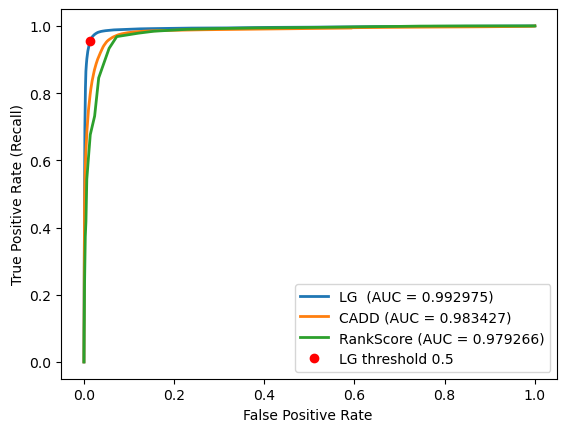

In [21]:
roc_curve_compare(df_merge_out_BP_2)

### 2. predict clinvar data's uncertain:
just see counts, don't know true results

In [22]:
df_out_uncertain = df_merge_out.loc[df_merge_out['CLNSIG'] == 'uncertain']
df_out_uncertain

,prediction,score,CADD,RankScore,CLNSIG,Consequence
0,1.0,0.519,26.600,24.0,uncertain,missense_variant
3,1.0,0.687,28.200,22.0,uncertain,missense_variant
5,1.0,0.772,31.000,22.0,uncertain,missense_variant
7,1.0,1.000,34.000,25.0,uncertain,splice_donor_variant
14,1.0,0.572,26.100,23.0,uncertain,missense_variant
...,...,...,...,...,...,...
1468899,0.0,0.173,20.300,20.0,uncertain,missense_variant
1468901,0.0,0.001,8.642,9.0,uncertain,upstream_gene_variant
1468902,1.0,0.991,24.800,24.0,uncertain,splice_acceptor_variant
1468908,1.0,0.911,23.800,23.0,uncertain,missense_variant


In [23]:
# CLNSIG label encoder 
df_out_uncertain = df_out_uncertain.copy()

map_CLNSIG={'pathogenic':1,'benign':0}
df_out_uncertain['CLNSIG']=df_out_uncertain['CLNSIG'].map(lambda s: map_CLNSIG.get(s) if s in map_CLNSIG else s)
df_out_uncertain["CLNSIG"].value_counts()

uncertain    591102
Name: CLNSIG, dtype: int64

In [24]:
df_out_uncertain['prediction'].value_counts()

0.0    393096
1.0    198006
Name: prediction, dtype: int64

### 3.  predict clinvar data: missense

In [25]:
# get missense variants
df_out_missen = df_merge_out.loc[df_merge_out['Consequence'].isin(['missense_variant'])]

# and only keep benign & pathogenic that we know turth
df_out_missen= df_out_missen.loc[df_out_missen['CLNSIG'].isin(['benign','pathogenic'])]
df_out_missen

,prediction,score,CADD,RankScore,CLNSIG,Consequence
2,1.0,0.732,31.000,21.0,benign,missense_variant
16,0.0,0.091,24.700,21.0,benign,missense_variant
18,0.0,0.111,8.737,11.0,benign,missense_variant
23,0.0,0.034,0.045,11.0,benign,missense_variant
26,0.0,0.004,23.600,8.0,benign,missense_variant
...,...,...,...,...,...,...
1468893,1.0,0.819,22.300,26.0,pathogenic,missense_variant
1468894,1.0,0.609,17.740,22.0,pathogenic,missense_variant
1468896,0.0,0.420,15.650,20.0,pathogenic,missense_variant
1468897,0.0,0.028,8.074,15.0,pathogenic,missense_variant


In [26]:
# for R plot

df_out_missen_PLOT = df_out_missen[['prediction','score','CADD','RankScore','CLNSIG']]
df_out_missen_PLOT.to_csv('/Users/nancy/Desktop/RS_projects/data/04_ML_modify/02_evaluate/02_12feats_LG_pred_CLINVAR_missense.csv',index=False)

In [27]:
df_out_missen['CLNSIG'].value_counts()

benign        63857
pathogenic    47039
Name: CLNSIG, dtype: int64

In [28]:
# CLNSIG label encoder 
df_out_missen_1 = df_out_missen.copy()

map_CLNSIG={'pathogenic':1,'benign':0}
df_out_missen_1['CLNSIG']=df_out_missen_1['CLNSIG'].map(lambda s: map_CLNSIG.get(s) if s in map_CLNSIG else s)
df_out_missen_1["CLNSIG"].value_counts()

0    63857
1    47039
Name: CLNSIG, dtype: int64

#### LG

In [29]:
##  Estimating accuracy : https://www.notion.so/Q_General_Code-0a62028772ab2f20bc1fdbd8225c6cee?pvs=2#7259559d929f2dda8da82f20e7ec116c
y_true_1 = df_out_missen_1['CLNSIG'].values
y_pred_l = df_out_missen_1['prediction'].values


auc_l = float((y_true_1 == y_pred_l).mean()*100)
print('Logistic regression accuracy for whole clinvar missense variants:', auc_l)

Logistic regression accuracy for whole clinvar missense variants: 91.06009233876784


In [30]:
##  TN TP, FN FP counts  : https://ubc-cs.github.io/cpsc330/lectures/09_classification-metrics.html#confusion-matrix
from sklearn.metrics import confusion_matrix

TN, FP, FN, TP = confusion_matrix(y_true_1,y_pred_l).ravel()
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)
print('TP :',TP)

print(classification_report(y_true_1,y_pred_l, target_names=["benign", "pathogenic"]))

TN: 58569
FP: 5288
FN: 4626
TP : 42413
              precision    recall  f1-score   support

      benign       0.93      0.92      0.92     63857
  pathogenic       0.89      0.90      0.90     47039

    accuracy                           0.91    110896
   macro avg       0.91      0.91      0.91    110896
weighted avg       0.91      0.91      0.91    110896



#### ROC

In [31]:
## drop null!!!
df_out_missen_2 = df_out_missen_1.dropna()
df_out_missen_2['CLNSIG'].value_counts()

0    63857
1    47039
Name: CLNSIG, dtype: int64

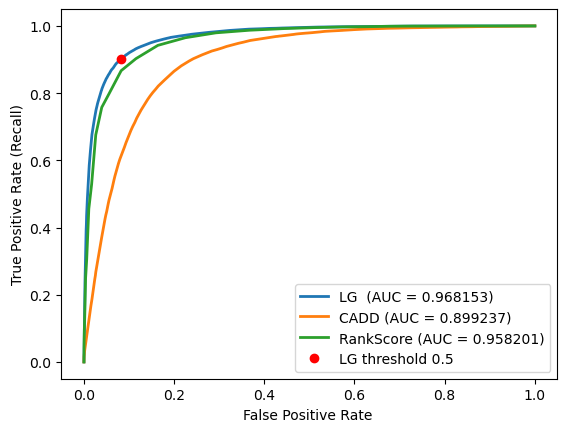

In [32]:
roc_curve_compare(df_out_missen_2)

### 4.  predict clinvar data: splice

In [33]:
splice_variant = ['splice_region_variant','splice_polypyrimidine_tract_variant','splice_donor_variant','splice_acceptor_variant','splice_donor_region_variant','splice_donor_5th_base_variant']
df_out_splice = df_merge_out.loc[df_merge_out['Consequence'].isin(splice_variant)]

# and only keep benign & pathogenic that we know turth
df_out_splice= df_out_splice.loc[df_out_splice['CLNSIG'].isin(['benign','pathogenic'])]
df_out_splice

,prediction,score,CADD,RankScore,CLNSIG,Consequence
8,0.0,0.030,5.182,12.0,benign,splice_region_variant
9,1.0,0.858,10.420,13.0,benign,splice_acceptor_variant
10,0.0,0.017,1.455,10.0,benign,splice_region_variant
12,0.0,0.006,2.864,15.0,benign,splice_polypyrimidine_tract_variant
13,0.0,0.005,2.623,15.0,benign,splice_polypyrimidine_tract_variant
...,...,...,...,...,...,...
1468734,0.0,0.000,1.013,2.0,benign,splice_polypyrimidine_tract_variant
1468786,1.0,1.000,34.000,25.0,pathogenic,splice_donor_variant
1468829,1.0,0.999,29.100,24.0,pathogenic,splice_donor_variant
1468904,1.0,0.999,25.700,22.0,benign,splice_donor_variant


In [34]:
# for R plot

df_out_splice_plot = df_out_splice[['prediction','score','CADD','RankScore','CLNSIG']]

df_out_splice_plot.to_csv('/Users/nancy/Desktop/RS_projects/data/04_ML_modify/02_evaluate/02_12feats_LG_pred_CLINVAR_splice.csv',index=False)

In [35]:
df_out_splice['CLNSIG'].value_counts()

benign        76973
pathogenic    26831
Name: CLNSIG, dtype: int64

#### LG

In [36]:
# CLNSIG label encoder 
df_out_splice_1 = df_out_splice.copy()

map_CLNSIG={'pathogenic':1,'benign':0}
df_out_splice_1['CLNSIG']=df_out_splice_1['CLNSIG'].map(lambda s: map_CLNSIG.get(s) if s in map_CLNSIG else s)
df_out_splice_1["CLNSIG"].value_counts()

0    76973
1    26831
Name: CLNSIG, dtype: int64

In [37]:
##  Estimating accuracy : https://www.notion.so/Q_General_Code-0a62028772ab2f20bc1fdbd8225c6cee?pvs=2#7259559d929f2dda8da82f20e7ec116c


y_true = df_out_splice_1['CLNSIG'].values
y_pred_l = df_out_splice_1['prediction'].values

# accuracy
auc_l = float((y_true == y_pred_l).mean()*100)

print('Logistic regression accuracy for whole clinvar splice variants:', auc_l,'\n')


TN, FP, FN, TP = confusion_matrix(y_true, y_pred_l).ravel()
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)
print('TP:',TP,'\n')

## other score/percentage

print (classification_report(y_true,y_pred_l, target_names=["benign", "pathogenic"]))


Logistic regression accuracy for whole clinvar splice variants: 98.18793110092096 

TN: 75953
FP: 1020
FN: 861
TP: 25970 

              precision    recall  f1-score   support

      benign       0.99      0.99      0.99     76973
  pathogenic       0.96      0.97      0.97     26831

    accuracy                           0.98    103804
   macro avg       0.98      0.98      0.98    103804
weighted avg       0.98      0.98      0.98    103804



#### ROC

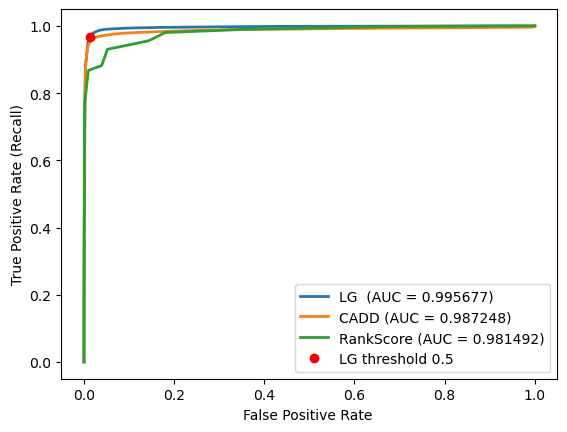

In [38]:
## drop null!!!
df_out_splice_2 = df_out_splice_1.dropna()
df_out_splice_2['CLNSIG'].value_counts()


roc_curve_compare(df_out_splice_2)